In [1]:
from functools import partial
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import matplotlib.pyplot as plt
from CIFARLoader import save_cifar, check_cifar, check_output_path
import easydict 


In [2]:
OUTPUT_DIR = 'cifar10_data'

In [3]:
args = easydict.EasyDict({
    "dataset": "cifar10",
    "output": "cifar10_data",
    "name_with_batch_index": False
})

check_output_path(args.output)

if check_cifar(args.dataset):
    save_cifar(args)


                      /-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/-\|/

Saving train images: 100%|██████████| 50000/50000 [00:19<00:00, 2508.59it/s]


                     /-\|/-\|/-\|/

Saving test images: 100%|██████████| 10000/10000 [00:04<00:00, 2435.85it/s]


In [4]:
import glob

IMAGE_COUNT = len(glob.glob(OUTPUT_DIR + '/' + 'train'  + '/*/*'))

print(IMAGE_COUNT)

50000


In [5]:
BATCH_SIZE = 100

STEPS_PER_EPOCH = np.ceil(IMAGE_COUNT/BATCH_SIZE)

IMAGE_COUNT, STEPS_PER_EPOCH

(50000, 500.0)

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range= 0.2, 
    shear_range= 0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range= 0.2, 
    shear_range= 0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

Alexnet

In [7]:
DefaultAlexConv2D = partial(keras.layers.Conv2D, strides=(4, 4) , activation = tf.nn.relu)
DefaultAlexMaxPool2D = partial(keras.layers.MaxPool2D, padding = 'SAME', data_format='channels_last')
DefaultBatchNormalize = partial(tf.keras.layers.BatchNormalization)
DefaultDropout = partial(tf.keras.layers.Dropout, rate = 0.5)

In [8]:
from datetime import datetime

date_time = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")

alex_net_model = keras.models.Sequential([
    DefaultAlexConv2D(filters=96, kernel_size=(11, 11), input_shape=(227, 227, 3), padding='VALID'),
    DefaultBatchNormalize(),
    DefaultAlexMaxPool2D(pool_size=(3, 3)), 
    DefaultAlexConv2D(filters = 256, kernel_size = (5, 5), padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexMaxPool2D(pool_size=(3, 3)), 
    DefaultAlexConv2D(filters = 384, kernel_size = (3, 3),  padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexConv2D(filters = 384, kernel_size = (3, 3),  padding = 'SAME'),
    DefaultBatchNormalize(),
    DefaultAlexConv2D(filters = 256, kernel_size = (3, 3),  padding = 'SAME'),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation=tf.nn.relu),
    DefaultDropout(),
    keras.layers.Dense(4096, activation=tf.nn.relu),
    DefaultDropout(),
    keras.layers.Dense(10, activation=tf.nn.softmax)
    ], name="alex_net_model_" + date_time)

In [9]:
alex_net_model.summary()

Model: "alex_net_model_02_02_2022_04_49_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (No

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,_,logs={}):
        if (logs.get("accuracy")==0.98 and logs.get("loss")<0.03):
            print("\nReached 98% accuracy so stopping training")
            self.model.stop_training =True
callbacks = myCallback()

In [14]:
alex_net_model.compile(loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'], optimizer=tf.optimizers.Adam())

history = alex_net_model.fit(train_datagen.flow_from_directory(OUTPUT_DIR + '/' + 'train', target_size=(227,227), 
                                                               batch_size=BATCH_SIZE, class_mode='categorical'),
    
    validation_data= valid_datagen.flow_from_directory(OUTPUT_DIR + '/' + 'test', target_size=(227,227), 
                                                       batch_size=BATCH_SIZE, class_mode='categorical'),
    callbacks=[callbacks], verbose=2, workers=20, 
    epochs=2, steps_per_epoch=STEPS_PER_EPOCH, )


Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/2
500/500 - 69s - loss: 1.4672 - accuracy: 0.4793 - val_loss: 1.6879 - val_accuracy: 0.4062
Epoch 2/2
500/500 - 70s - loss: 1.3937 - accuracy: 0.5076 - val_loss: 1.5078 - val_accuracy: 0.4540


Training accuracy:  0.5076199769973755
Training loss:  1.3936787843704224
Validation accuracy:  0.45399999618530273
Validation loss:  1.5077646970748901


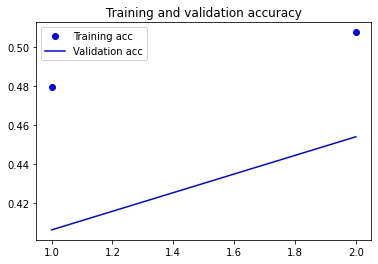

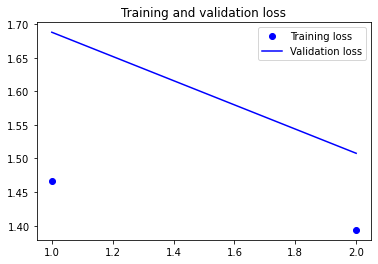

In [15]:

acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("Training accuracy: ", acc)
print("Training loss: ", loss)

print("Validation accuracy: ", val_acc)
print("Validation loss: ", val_loss)

# Plotting the graphs to visualize the trend of accuracy and loss

epochs = range(1, len(history.history['accuracy'])+1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
alex_net_model.save('alex_net_model_' + date_time + '.h5')
